<a href="https://colab.research.google.com/github/Cimbir/Store-Sales-Forecasting/blob/main/model_n_beats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 87.6 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
!mkdir ~/.kaggle
!echo "{\"username\":\"dachisuramelashvili\",\"key\":\"4202ec60e20b612a9947450bb8aeebb5\"}" > ~/.kaggle
!cp /content/drive/MyDrive/ML/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

/bin/bash: line 1: /root/.kaggle: Is a directory


In [3]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 750MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [4]:
!unzip train.csv.zip
!unzip stores.csv.zip
!unzip features.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  test.csv.zip
  inflating: test.csv                


In [5]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from time import time
import pickle
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [6]:
import warnings
warnings.filterwarnings('ignore')

# Evaluate

In [7]:
def WMAE(dataset, real, predict):
    weights = dataset['IsHoliday_x'].apply(lambda x: 5 if x else 1)
    return (np.sum(weights * abs(real - predict)) / np.sum(weights))

# Get Data

In [8]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [17]:
df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1)

df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Unique stores: {df['Store'].nunique()}")
print(f"Unique departments: {df['Dept'].nunique()}")

display(df.head())

Dataset shape: (421570, 16)
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Unique stores: 45
Unique departments: 81


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


# Preprocessing

In [51]:
class CleaningPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, nan_vars):
        self.nan_vars = nan_vars

    def fit(self, X, y=None):
        self.var_to_mean = {}
        for var in self.nan_vars:
            self.var_to_mean[var] = X[var].mean()
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.nan_vars:
            X[var].fillna(self.var_to_mean[var], inplace=True)
        return X

class EncoderPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Type'] = X['Type'].astype('category').cat.codes
        X['IsHoliday_x'] = X['IsHoliday_x'].astype(int)
        return X

class FormatterPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X.sort_values(['Date', 'Store', 'Dept'])
        X['Store_Dept'] = X['Store'].astype(str) + '_' + X['Dept'].astype(str)
        return X

class SelectionPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, feature_cols):
        self.feature_cols = feature_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        available_features = [col for col in feature_cols if col in X.columns]
        X = X[available_features]
        return X

class ScalerPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X)
        return self

    def transform(self, X):
        X = X.copy()
        X = self.scaler.transform(X)
        return X

# N-BEATS Model Implementation

## Basis

In [11]:
class GenericBasis(nn.Module):
    """
    Generic basis function (simple linear transformation)
    """
    def __init__(self, backcast_size, forecast_size):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta, input_size, mode):
        if mode == 'backcast':
            return theta[:, :self.backcast_size]
        else:  # forecast
            return theta[:, :self.forecast_size]


class TrendBasis(nn.Module):
    """
    Trend basis function using polynomial basis
    """
    def __init__(self, degree_of_polynomial, backcast_size, forecast_size):
        super().__init__()
        self.degree_of_polynomial = degree_of_polynomial
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta, input_size, mode):
        batch_size = theta.size(0)

        if mode == 'backcast':
            t = torch.arange(0, self.backcast_size, dtype=torch.float32) / self.backcast_size
        else:  # forecast
            t = torch.arange(self.backcast_size, self.backcast_size + self.forecast_size, dtype=torch.float32) / self.backcast_size

        t = t.to(theta.device)
        T = torch.stack([t ** i for i in range(self.degree_of_polynomial + 1)], dim=0).T  # [time, degree]
        T = T.unsqueeze(0).expand(batch_size, -1, -1)  # [batch, time, degree]

        theta = theta.unsqueeze(-1)  # [batch, degree, 1]

        return torch.bmm(T, theta).squeeze(-1)  # [batch, time]


class SeasonalityBasis(nn.Module):
    """
    Seasonality basis function using Fourier series
    """
    def __init__(self, harmonics, backcast_size, forecast_size):
        super().__init__()
        self.harmonics = harmonics
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta, input_size, mode):
        batch_size = theta.size(0)

        if mode == 'backcast':
            t = torch.arange(0, self.backcast_size, dtype=torch.float32)
        else:  # forecast
            t = torch.arange(self.backcast_size, self.backcast_size + self.forecast_size, dtype=torch.float32)

        t = t.to(theta.device)

        # Create Fourier basis
        S = torch.zeros(len(t), 2 * self.harmonics).to(theta.device)
        for i in range(self.harmonics):
            S[:, 2*i] = torch.sin(2 * np.pi * (i + 1) * t / self.backcast_size)
            S[:, 2*i + 1] = torch.cos(2 * np.pi * (i + 1) * t / self.backcast_size)

        S = S.unsqueeze(0).expand(batch_size, -1, -1)  # [batch, time, 2*harmonics]
        theta = theta.unsqueeze(-1)  # [batch, 2*harmonics, 1]

        return torch.bmm(S, theta).squeeze(-1)  # [batch, time]

## Block

In [12]:
class NBeatsBlock(nn.Module):
    """
    N-BEATS block which takes a basis expansion as an argument.
    Modified to handle multivariate input (sales + features).
    """
    def __init__(self, input_size, feature_size, theta_size, basis_function, layers, layer_size):
        super().__init__()
        self.input_size = input_size  # backcast_length
        self.feature_size = feature_size  # number of features
        self.theta_size = theta_size
        self.basis_function = basis_function

        # Total input size is backcast_length * (1 + feature_size)
        # 1 for sales + feature_size for additional features
        total_input_size = input_size * (1 + feature_size)

        # Fully connected stack
        layers_list = [nn.Linear(total_input_size, layer_size), nn.ReLU()]
        for _ in range(layers - 1):
            layers_list.append(nn.Linear(layer_size, layer_size))
            layers_list.append(nn.ReLU())

        self.fc_stack = nn.Sequential(*layers_list)

        # Theta layers (coefficients for basis functions)
        self.theta_b_fc = nn.Linear(layer_size, theta_size)
        self.theta_f_fc = nn.Linear(layer_size, theta_size)

    def forward(self, x, features):
        # x shape: [batch_size, backcast_length] (sales data)
        # features shape: [batch_size, backcast_length, feature_size]

        # Flatten and concatenate sales with features
        batch_size = x.size(0)
        x_flat = x.flatten(1)  # [batch_size, backcast_length]
        features_flat = features.flatten(1)  # [batch_size, backcast_length * feature_size]
        combined_input = torch.cat([x_flat, features_flat], dim=1)  # [batch_size, total_input_size]

        # Pass through fully connected stack
        h = self.fc_stack(combined_input)

        # Get theta coefficients
        theta_b = self.theta_b_fc(h)
        theta_f = self.theta_f_fc(h)

        # Generate basis functions and apply theta coefficients
        backcast = self.basis_function(theta_b, x.size(-1), 'backcast')
        forecast = self.basis_function(theta_f, x.size(-1), 'forecast')

        return backcast, forecast

## Stack

In [13]:
class NBeatsStack(nn.Module):
    """
    N-BEATS stack containing multiple blocks of the same type
    """
    def __init__(self,
                 stack_type,
                 backcast_length,
                 forecast_length,
                 feature_size,
                 nb_blocks,
                 hidden_layer_units,
                 nb_layers,
                 theta_dim,
                 share_weights=False):
        super().__init__()

        self.stack_type = stack_type
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.feature_size = feature_size
        self.nb_blocks = nb_blocks
        self.share_weights = share_weights

        # Create basis function based on stack type
        if stack_type == 'generic':
            self.basis_function = GenericBasis(backcast_length, forecast_length)
            theta_size = backcast_length + forecast_length
        elif stack_type == 'trend':
            self.basis_function = TrendBasis(theta_dim - 1, backcast_length, forecast_length)
            theta_size = theta_dim
        elif stack_type == 'seasonality':
            self.basis_function = SeasonalityBasis(theta_dim // 2, backcast_length, forecast_length)
            theta_size = theta_dim
        else:
            raise ValueError(f"Unknown stack type: {stack_type}")

        # Create blocks
        self.blocks = nn.ModuleList()

        if share_weights and nb_blocks > 1:
            # Share weights across blocks in the stack
            shared_block = NBeatsBlock(
                input_size=backcast_length,
                feature_size=feature_size,
                theta_size=theta_size,
                basis_function=self.basis_function,
                layers=nb_layers,
                layer_size=hidden_layer_units
            )
            self.blocks = nn.ModuleList([shared_block for _ in range(nb_blocks)])
        else:
            # Create separate blocks
            for _ in range(nb_blocks):
                block = NBeatsBlock(
                    input_size=backcast_length,
                    feature_size=feature_size,
                    theta_size=theta_size,
                    basis_function=self.basis_function,
                    layers=nb_layers,
                    layer_size=hidden_layer_units
                )
                self.blocks.append(block)

    def forward(self, x, features):
        """
        Forward pass through the stack

        Args:
            x: [batch_size, backcast_length] - sales residuals
            features: [batch_size, backcast_length, feature_size] - external features

        Returns:
            residuals: [batch_size, backcast_length] - updated residuals after this stack
            forecast: [batch_size, forecast_length] - forecast contribution from this stack
        """
        residuals = x
        forecast = torch.zeros(x.size(0), self.forecast_length).to(x.device)

        for block in self.blocks:
            backcast, block_forecast = block(residuals, features)
            residuals = residuals - backcast
            forecast = forecast + block_forecast

        return residuals, forecast

## Model

In [14]:
class NBeatsModel(nn.Module):
    """
    N-BEATS model implementation with multivariate support
    """
    def __init__(self,
                 backcast_length=52,  # Look back 20 weeks
                 forecast_length=10,  # Forecast 10 weeks ahead
                 feature_size=7,      # Number of additional features
                 stack_types=['trend', 'seasonality', 'generic'],
                 nb_blocks_per_stack=3,
                 hidden_layer_units=512,
                 nb_layers=4,
                 share_weights_in_stack=False,
                 thetas_dim=[4, 8, 8]):
        super().__init__()

        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.feature_size = feature_size
        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.hidden_layer_units = hidden_layer_units
        self.nb_layers = nb_layers
        self.thetas_dim = thetas_dim

        # Create stacks
        self.stacks = nn.ModuleList()

        for stack_id, stack_type in enumerate(stack_types):
            if stack_type == 'generic':
                basis_function = GenericBasis(backcast_length, forecast_length)
                theta_size = backcast_length + forecast_length
            elif stack_type == 'trend':
                basis_function = TrendBasis(thetas_dim[stack_id] - 1, backcast_length, forecast_length)
                theta_size = thetas_dim[stack_id]
            elif stack_type == 'seasonality':
                basis_function = SeasonalityBasis(thetas_dim[stack_id] // 2, backcast_length, forecast_length)
                theta_size = thetas_dim[stack_id]

            # Create blocks for this stack
            blocks = nn.ModuleList()
            for _ in range(nb_blocks_per_stack):
                block = NBeatsBlock(
                    input_size=backcast_length,
                    feature_size=feature_size,
                    theta_size=theta_size,
                    basis_function=basis_function,
                    layers=nb_layers,
                    layer_size=hidden_layer_units
                )
                blocks.append(block)

            self.stacks.append(blocks)

    def forward(self, x, features):
        # x shape: [batch_size, backcast_length] (sales data)
        # features shape: [batch_size, backcast_length, feature_size]
        residuals = x
        forecast = torch.zeros(x.size(0), self.forecast_length).to(x.device)

        for stack in self.stacks:
            stack_residuals = residuals
            stack_forecast = torch.zeros_like(forecast)

            for block in stack:
                backcast, block_forecast = block(stack_residuals, features)
                stack_residuals = stack_residuals - backcast
                stack_forecast = stack_forecast + block_forecast

            residuals = stack_residuals
            forecast = forecast + stack_forecast

        return forecast

# Dataset

In [15]:
class SalesDataset(Dataset):
    def __init__(self, sales_data, features_data, backcast_length, forecast_length):
        self.sales_data = sales_data
        self.features_data = features_data
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

        # Create sequences
        self.sequences = []
        for i in range(len(sales_data) - backcast_length - forecast_length + 1):
            # Sales sequences
            sales_backcast = sales_data[i:i + backcast_length]
            sales_forecast = sales_data[i + backcast_length:i + backcast_length + forecast_length]

            # Feature sequences (backcast only, features aren't predicted)
            features_backcast = features_data[i:i + backcast_length]

            self.sequences.append((sales_backcast, features_backcast, sales_forecast))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sales_backcast, features_backcast, sales_forecast = self.sequences[idx]
        return (torch.FloatTensor(sales_backcast),
                torch.FloatTensor(features_backcast),
                torch.FloatTensor(sales_forecast))

# Prepare Dataset

In [52]:
# Handle missing data
nan_vars = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Select features to use (excluding target and identifiers)
feature_cols = ['Store_Dept', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
                'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']

# Create preprocessing pipeline
preprocessor = Pipeline([
    ('cleaner', CleaningPreprocessor(nan_vars=nan_vars)),
    ('encoder', EncoderPreprocessor()),
    ('formatter', FormatterPreprocessor()),
    ('selector', SelectionPreprocessor(feature_cols=feature_cols)),
    ('scaler', ScalerPreprocessor())
])

# Fit and transform the data
df_p = preprocessor.fit_transform(df.copy())

df_p.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [41]:
df_sales = df_p['Weekly_Sales'].values
df_feats =

# Split


In [31]:
train_end_date = pd.to_datetime('2012-07-20')

df_train = df[df['Date'] < train_end_date]
df_val = df[df['Date'] >= train_end_date]

In [33]:
print(f"Train sales data size: {len(df_train)}")
print(f"Test sales data size: {len(df_val)}")
print(f"Train features data shape: {df_train.shape}")
print(f"Test features data shape: {df_val.shape}")

Train sales data size: 377155
Test sales data size: 44415
Train features data shape: (377155, 15)
Test features data shape: (44415, 15)


In [32]:
df_train = df_train.set_index('Date')
df_val = df_val.set_index('Date')

In [ ]:
# Create datasets
train_dataset = TimeSeriesDataset(sales_normalized, train_features_data, BACKCAST_LENGTH, FORECAST_LENGTH)
test_dataset = TimeSeriesDataset(test_sales_data, test_features_data, BACKCAST_LENGTH, FORECAST_LENGTH)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Fit Model

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('cleaner', CleaningPreprocessor(nan_vars=nan_vars)),
    ('encoder', EncoderPreprocessor())
])

In [ ]:
pipeline.fit(sd_train_df)
sd_train_df = pipeline.transform(sd_train_df)
sd_val_df = pipeline.transform(sd_val_df)

In [ ]:
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 51)

exog_vars_list = ['IsHoliday_x', 'Temperature',	'Fuel_Price',
                  'MarkDown1', 'MarkDown2',	'MarkDown3', 'MarkDown4',	'MarkDown5',
                  'CPI',	'Unemployment',	'Type',	'Size']

exog_vars_train = sd_train_df[exog_vars_list]

model = SARIMAX(
    sd_train_df['Weekly_Sales'],
    exog=exog_vars_train,
    order=my_order,
    seasonal_order=my_seasonal_order
)

In [ ]:
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

KeyboardInterrupt: 

In [ ]:
print(model_fit.summary())

NameError: name 'model_fit' is not defined

In [ ]:
exog_vars_val = sd_val_df[exog_vars_list]
predictions = model_fit.forecast(len(sd_val_df), exog=exog_vars_val)
predictions = pd.Series(predictions, index=sd_val_df.index)
residuals = sd_val_df['Weekly_Sales'].values - predictions.values
residuals = pd.Series(residuals, index=sd_val_df.index)

NameError: name 'model_fit' is not defined

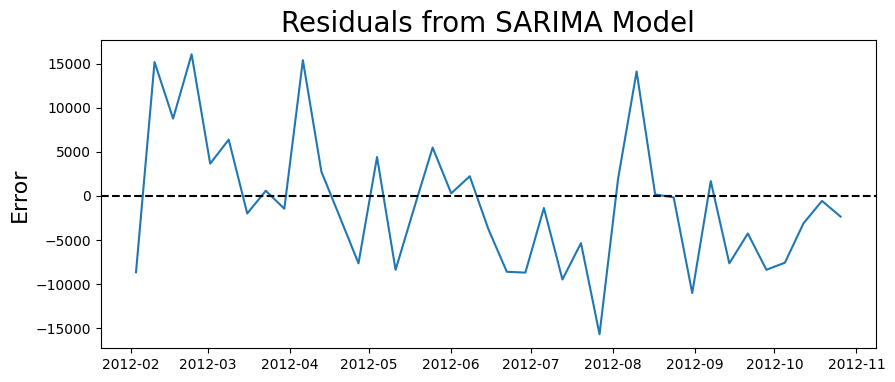

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.savefig(f'residuals_from_sarima_{store_id}_{dept_id}.png')

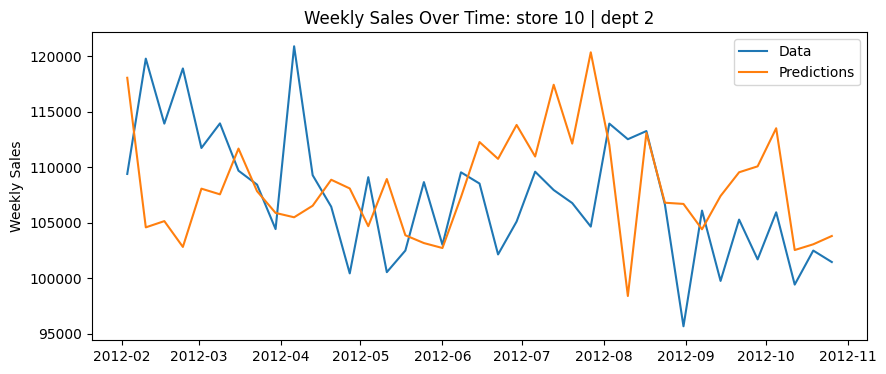

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(sd_val_df['Weekly_Sales'])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'))

plt.title(f'Weekly Sales Over Time: store {store_id} | dept {dept_id}')
plt.ylabel('Weekly Sales')
plt.savefig(f'weekly_sales_over_time_{store_id}_{dept_id}.png')

# Grid Search

In [ ]:
import itertools
from sklearn.metrics import mean_squared_error

def sarimax_grid_search(y, exog, p, d, q, P, D, Q, S, store_id, dept_id):
    best_wmae = float('inf')
    best_order = None
    best_seasonal_order = None
    best_model = None

    # Generate all possible combinations of p, d, q
    pdq = list(itertools.product(p, d, q))
    # Generate all possible combinations of P, D, Q
    seasonal_pdq = [(x[0], x[1], x[2], S) for x in list(itertools.product(P, D, Q))]

    print('Running Grid Search...')

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(y,
                                exog=exog,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                model_fit = model.fit(disp=False) # disp=False to suppress convergence output

                # Make predictions on the validation set
                exog_val = sd_val_df[exog_vars_list] # Use the preprocessed validation exogenous variables
                predictions = model_fit.forecast(steps=len(sd_val_df), exog=exog_val)

                # Ensure predictions are positive if weekly sales should be positive
                predictions[predictions < 0] = 0

                # Evaluate the model using WMAE
                wmae = WMAE(sd_val_df, sd_val_df['Weekly_Sales'], predictions)

                # Print the WMAE
                print(f'SARIMAX({param})x({param_seasonal}) - WMAE: {wmae:.3f}')

                if wmae < best_wmae:
                    best_wmae = wmae
                    best_order = param
                    best_seasonal_order = param_seasonal
                    best_model = model_fit

            except Exception as e:
                print(f'Could not fit SARIMAX({param})x({param_seasonal}): {e}')
                continue

    print('\nBest SARIMAX Model:')
    print(f'Order: {best_order}')
    print(f'Seasonal Order: {best_seasonal_order}')
    print(f'Validation WMAE: {best_wmae:.3f}')

    return best_order, best_seasonal_order, best_wmae, best_model

In [ ]:
# Define parameter ranges for grid search
p = range(0, 3) # p values for the non-seasonal part
d = range(0, 2) # d values for the non-seasonal differencing
q = range(0, 3) # q values for the non-seasonal part
P = range(0, 3) # P values for the seasonal part
D = range(0, 2) # D values for the seasonal differencing
Q = range(0, 3) # Q values for the seasonal part
S = 52        # Seasonal period (51 weeks in a year)

# Select the time series data and exogenous variables for training
y_train = sd_train_df['Weekly_Sales']
exog_train = sd_train_df[exog_vars_list]

# Run the grid search
best_order, best_seasonal_order, best_wmae, best_model = sarimax_grid_search(
    y_train,
    exog_train,
    p, d, q,
    P, D, Q, S,
    store_id,
    dept_id
)

Running Grid Search...
SARIMAX((0, 0, 0))x((0, 0, 0, 52)) - WMAE: 11782.130
SARIMAX((0, 0, 0))x((0, 0, 1, 52)) - WMAE: 8805.343
SARIMAX((0, 0, 0))x((0, 0, 2, 52)) - WMAE: 11767.754
SARIMAX((0, 0, 0))x((0, 1, 0, 52)) - WMAE: 17466.157
SARIMAX((0, 0, 0))x((0, 1, 1, 52)) - WMAE: 6068.560
SARIMAX((0, 0, 0))x((0, 1, 2, 52)) - WMAE: 6068.560
SARIMAX((0, 0, 0))x((1, 0, 0, 52)) - WMAE: 5478.621
SARIMAX((0, 0, 0))x((1, 0, 1, 52)) - WMAE: 5104.017
SARIMAX((0, 0, 0))x((1, 0, 2, 52)) - WMAE: 11767.754
SARIMAX((0, 0, 0))x((1, 1, 0, 52)) - WMAE: 6068.560
SARIMAX((0, 0, 0))x((1, 1, 1, 52)) - WMAE: 6068.560
SARIMAX((0, 0, 0))x((1, 1, 2, 52)) - WMAE: 6068.560
SARIMAX((0, 0, 0))x((2, 0, 0, 52)) - WMAE: 11767.754
SARIMAX((0, 0, 0))x((2, 0, 1, 52)) - WMAE: 11767.754
SARIMAX((0, 0, 0))x((2, 0, 2, 52)) - WMAE: 11767.754
SARIMAX((0, 0, 0))x((2, 1, 0, 52)) - WMAE: 6068.560
SARIMAX((0, 0, 0))x((2, 1, 1, 52)) - WMAE: 6068.560
SARIMAX((0, 0, 0))x((2, 1, 2, 52)) - WMAE: 6068.560
SARIMAX((0, 0, 1))x((0, 0, 0, 52))

In [ ]:
exog_vars_val = sd_val_df[exog_vars_list]
predictions = best_model.forecast(len(sd_val_df), exog=exog_vars_val)
predictions = pd.Series(predictions, index=sd_val_df.index)
residuals = sd_val_df['Weekly_Sales'].values - predictions.values
residuals = pd.Series(residuals, index=sd_val_df.index)

# Start MLFlow

In [ ]:
!pip install dagshub mlflow -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import dagshub
import mlflow
from mlflow.models.signature import infer_signature
dagshub.init(repo_owner='Cimbir', repo_name='Store-Sales-Forecasting', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=4c093bef-0a12-4930-8c4e-90bfbe736475&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=fd1b0f3286ab083dde56113764774049b0851bdb814f232a8a8edb1fb4d77aa7




Accessing as Cimbir

Initialized MLflow to track repo "Cimbir/Store-Sales-Forecasting"

Repository Cimbir/Store-Sales-Forecasting initialized!

In [ ]:
mlflow.set_experiment('SARIMA_Training')

<Experiment: artifact_location='mlflow-artifacts:/eab27d284ccf4e2c9217f41e9914a0b4', creation_time=1751109185006, experiment_id='0', last_update_time=1751109185006, lifecycle_stage='active', name='SARIMA_Training', tags={}>

In [ ]:
with mlflow.start_run(run_name='SARIMA_Preprocessor') as run:
  mlflow.log_param('cleaner', 'CleaningPreprocessor')
  mlflow.log_param('nan_vars', nan_vars)
  mlflow.log_param('encoder', 'EncoderPreprocessor')

  pickle.dump(pipeline, open('preprocessor_pipeline.pkl', 'wb'))
  mlflow.log_artifact('preprocessor_pipeline.pkl')

🏃 View run SARIMA_Preprocessor at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/0/runs/2b847b20f52d4dea8f1a01a935b3faf3
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/0


In [ ]:
with mlflow.start_run(run_name=f'SARIMA_Model_{store_id}_{dept_id}_s_{S}') as run:
  mlflow.log_param('store_id', store_id)
  mlflow.log_param('dept_id', dept_id)

  mlflow.log_param('p', p)
  mlflow.log_param('d', d)
  mlflow.log_param('q', q)
  mlflow.log_param('P', P)
  mlflow.log_param('D', D)
  mlflow.log_param('Q', Q)
  mlflow.log_param('S', S)

  mlflow.log_param('exog_vars_list', exog_vars_list)

  mlflow.log_param('best_order', best_order)
  mlflow.log_param('best_seasonal_order', best_seasonal_order)
  mlflow.log_metric('best_wmae', best_wmae)

  mlflow.log_text(str(best_model.summary()), 'model_summary.txt')

  # Save the best_model using pickle and log it as an artifact
  pickle.dump(best_model, open('sarima_best_model.pkl', 'wb'))
  mlflow.log_artifact('sarima_best_model.pkl')

  # predictions_val = best_model.forecast(steps=len(sd_val_df), exog=sd_val_df[exog_vars_list])
  # predictions_val[predictions_val < 0] = 0
  # signature = infer_signature(sd_val_df[exog_vars_list], predictions_val)
  # mlflow.statsmodels.log_model(best_model, 'sarima_model', signature=signature)

  mlflow.log_artifact(f'residuals_from_sarima_{store_id}_{dept_id}.png')
  mlflow.log_artifact(f'weekly_sales_over_time_{store_id}_{dept_id}.png')

🏃 View run SARIMA_Model_10_2_s_51 at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/0/runs/29769c6ee6c24b7faebf5fa649bfb7b6
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/0
